# 데이터 수집

In [1]:
import yfinance as yf
import pandas as pd

def yuan_indicator():
    tickers = {
    "Shanghai Composite": "000001.SS",
    "Shenzhen Component": "399001.SZ",
    "Hang Seng": "^HSI",
    "Hang Seng China Enterprises": "^HSCE"
    }
    
    data_list = []
    
    for name, symbol in tickers.items():
        ticker = yf.Ticker(symbol)
        df = ticker.history(period="25y", interval="1d")
        df = df.reset_index()
        
    
        df = df[["Date", "Open", "High", "Low", "Close"]]
        df = df.rename(columns={
            "Open": f"{name}_Open",
            "High": f"{name}_High",
            "Low": f"{name}_Low",
            "Close": f"{name}_Close"
        })
        df["Date"] = pd.to_datetime(df["Date"]).dt.tz_localize(None)
        data_list.append(df)
    
    df_merged = data_list[0]
    for df in data_list[1:]:
        df['Date']=pd.to_datetime(df['Date'])
        df_merged = pd.merge(df_merged, df, on="Date", how="inner")
    
    df_merged['Date'] = pd.to_datetime(df_merged['Date']).dt.strftime('%Y-%m-%d')
    df_merged['Date'] = pd.to_datetime(df_merged['Date'])
    return df_merged

In [2]:
import cloudpickle
with open("yuan_indicator.pkl", "wb") as f:
    cloudpickle.dump(yuan_indicator, f)

In [3]:
yuan_indi_df=yuan_indicator()

In [4]:
yuan_df=pd.read_csv('CNY_KRW 과거 데이터.csv')
yuan_df

,날짜,종가,시가,고가,저가,거래량,변동 %
0,2025- 07- 29,194.08,193.55,194.20,193.55,NaN,0.27%
1,2025- 07- 28,193.55,193.00,193.77,192.18,NaN,0.26%
2,2025- 07- 27,193.04,192.88,193.04,192.88,NaN,0.01%
3,2025- 07- 25,193.03,191.50,193.22,191.50,NaN,0.59%
4,2025- 07- 24,191.89,191.67,192.08,190.87,NaN,-0.07%
...,...,...,...,...,...,...,...
4843,2007- 01- 05,119.66,119.28,119.77,119.12,NaN,0.29%
4844,2007- 01- 04,119.31,119.19,119.45,119.06,NaN,0.69%
4845,2007- 01- 03,118.49,118.37,118.60,118.34,NaN,0.06%
4846,2007- 01- 02,118.42,118.62,118.76,118.36,NaN,-0.47%


In [5]:
yuan_df['변동 %']=yuan_df['변동 %'].apply(lambda x: x.replace('%','')).astype(float)
yuan_df=yuan_df.drop('거래량',axis=1)
yuan_df=yuan_df.rename(columns={'날짜':'Date','종가':'Close','시가':'Open','저가':'Low','고가':'High','변동 %':'Change'})

import datetime as dt
yuan_df['Date']=pd.to_datetime(pd.to_datetime(yuan_df['Date'],format='%Y- %m- %d').dt.strftime('%Y-%m-%d'))

In [6]:
yuan_df=yuan_df.sort_values('Date',ascending=True,ignore_index=True)

In [7]:
def CNYKRW():
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service
    from selenium.webdriver.common.by import By
    from datetime import datetime
    import pandas as pd
    import time

    df = pd.DataFrame(columns=["Date", "Close", "Open", "High", "Low", "Change"])
    
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    service = Service()
    
    driver = webdriver.Chrome(service=service, options=options)
    url = "https://kr.investing.com/currencies/cny-krw-historical-data"
    driver.get(url)
    time.sleep(5)

    def clean_number(text):
        return float(text.replace(',', '').replace('%', ''))

    for row in range(1, 3):  # tr[1], tr[2]
        try:
            date_xpath = f'//*[@id="__next"]/div[2]/div[2]/div[2]/div[1]/div[2]/div[3]/table/tbody/tr[{row}]/td[1]'
            close_xpath = f'//*[@id="__next"]/div[2]/div[2]/div[2]/div[1]/div[2]/div[3]/table/tbody/tr[{row}]/td[2]'
            open_xpath = f'//*[@id="__next"]/div[2]/div[2]/div[2]/div[1]/div[2]/div[3]/table/tbody/tr[{row}]/td[3]'
            high_xpath = f'//*[@id="__next"]/div[2]/div[2]/div[2]/div[1]/div[2]/div[3]/table/tbody/tr[{row}]/td[4]'
            low_xpath = f'//*[@id="__next"]/div[2]/div[2]/div[2]/div[1]/div[2]/div[3]/table/tbody/tr[{row}]/td[5]'
            change_xpath = f'//*[@id="__next"]/div[2]/div[2]/div[2]/div[1]/div[2]/div[3]/table/tbody/tr[{row}]/td[7]'

            date = driver.find_element(By.XPATH, date_xpath).text
            close = driver.find_element(By.XPATH, close_xpath).text
            open_ = driver.find_element(By.XPATH, open_xpath).text
            high = driver.find_element(By.XPATH, high_xpath).text
            low = driver.find_element(By.XPATH, low_xpath).text
            change = driver.find_element(By.XPATH, change_xpath).text

            # 날짜 변환
            date = datetime.strptime(date.replace('월', '-'), '%m- %d, %Y').date()

            new_row = {
                "Date": pd.to_datetime(date).normalize(),
                "Close": clean_number(close),
                "Open": clean_number(open_),
                "High": clean_number(high),
                "Low": clean_number(low),
                "Change": clean_number(change)
            }

            # 중복 확인 후 추가
            if new_row["Date"] not in df["Date"].values:
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

        except Exception as e:
            print(f"[❌ ERROR] Row {row}: {e}")
            continue

    df = df.sort_values("Date").reset_index(drop=True)
    driver.quit()
    return df

import cloudpickle
with open("yuan_real_times.pkl", "wb") as f:
    cloudpickle.dump(CNYKRW, f)

In [8]:
CNYKRW()

C:\Users\campus4D044\AppData\Local\Temp\ipykernel_12028\3163770458.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


,Date,Close,Open,High,Low,Change
0,2025-07-28,193.55,193.00,193.77,192.18,0.26
1,2025-07-29,193.88,193.55,194.20,193.55,0.17


In [9]:
yuan_df=pd.concat([yuan_df,CNYKRW()],ignore_index=True).drop_duplicates(subset='Date',keep='last',ignore_index=True)
yuan_df["Change"] = yuan_df["Close"].diff()

C:\Users\campus4D044\AppData\Local\Temp\ipykernel_12028\3163770458.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


In [10]:
yuan_df.to_csv('yuan_df.csv',index=False)

In [11]:
yuan_df

,Date,Close,Open,High,Low,Change
0,2007-01-01,118.98,118.98,118.98,118.98,NaN
1,2007-01-02,118.42,118.62,118.76,118.36,-0.56
2,2007-01-03,118.49,118.37,118.60,118.34,0.07
3,2007-01-04,119.31,119.19,119.45,119.06,0.82
4,2007-01-05,119.66,119.28,119.77,119.12,0.35
...,...,...,...,...,...,...
4843,2025-07-24,191.89,191.67,192.08,190.87,-0.13
4844,2025-07-25,193.03,191.50,193.22,191.50,1.14
4845,2025-07-27,193.04,192.88,193.04,192.88,0.01
4846,2025-07-28,193.55,193.00,193.77,192.18,0.51


In [12]:
all_df=pd.merge(yuan_indi_df,yuan_df,on='Date',how='inner')

In [15]:
all_df

,Date,Shanghai Composite_Open,Shanghai Composite_High,Shanghai Composite_Low,Shanghai Composite_Close,Shenzhen Component_Open,Shenzhen Component_High,Shenzhen Component_Low,Shenzhen Component_Close,Hang Seng_Open,...,Hang Seng_Close,Hang Seng China Enterprises_Open,Hang Seng China Enterprises_High,Hang Seng China Enterprises_Low,Hang Seng China Enterprises_Close,Close,Open,High,Low,Change
0,2007-01-04,2728.187988,2847.614990,2684.818115,2715.718994,6730.044644,6954.562146,6659.725120,6705.264648,20415.669922,...,20025.580078,10750.290039,10825.929688,10269.480469,10347.669922,119.31,119.19,119.45,119.06,0.82
1,2007-01-05,2668.576904,2685.803955,2617.019043,2641.333984,6667.645451,6777.734061,6584.986222,6706.165039,19890.150391,...,20211.279297,10071.009766,10264.139648,9938.549805,10235.459961,119.66,119.28,119.77,119.12,0.35
2,2007-01-08,2621.068115,2708.444092,2620.625000,2707.198975,6693.225122,6872.543433,6691.315475,6870.423340,19915.000000,...,20029.660156,9953.549805,10127.070312,9882.320312,10103.000000,120.07,119.63,120.22,119.63,0.41
3,2007-01-09,2711.049072,2809.394043,2691.360107,2807.803955,6894.123154,7095.650687,6848.623663,7078.510742,20162.539062,...,19898.080078,10291.990234,10323.309570,9856.040039,9967.480469,120.24,120.09,120.31,119.70,0.17
4,2007-01-10,2838.113037,2841.740967,2770.988037,2825.575928,7110.780458,7345.937988,7099.980774,7345.937988,19665.400391,...,19568.339844,9708.519531,9802.309570,9617.219727,9649.230469,120.13,120.39,120.62,120.09,-0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,2025-07-23,3588.877930,3613.021973,3577.593994,3582.298096,11101.320312,11158.219727,11042.200195,11059.040039,25348.300781,...,25538.070312,9156.259766,9242.990234,9111.179688,9241.200195,192.02,192.10,192.90,191.92,-0.43
4368,2025-07-24,3578.912109,3608.728027,3577.113037,3605.727051,11069.599609,11193.059570,11069.599609,11193.059570,25528.220703,...,25667.179688,9225.349609,9295.860352,9217.919922,9257.620117,191.89,191.67,192.08,190.87,-0.13
4369,2025-07-25,3604.449951,3610.029053,3586.219971,3593.655029,11196.200195,11210.910156,11139.320312,11168.139648,25531.589844,...,25388.349609,9216.179688,9216.179688,9124.150391,9150.490234,193.03,191.50,193.22,191.50,1.14
4370,2025-07-28,3594.230957,3606.273926,3582.148926,3597.937012,11176.389648,11226.179688,11114.919922,11217.580078,25458.869141,...,25562.130859,9173.080078,9234.450195,9143.400391,9177.150391,193.55,193.00,193.77,192.18,0.51


In [16]:
df_base=all_df

In [17]:
yuan_df

,Date,Close,Open,High,Low,Change
0,2007-01-01,118.98,118.98,118.98,118.98,NaN
1,2007-01-02,118.42,118.62,118.76,118.36,-0.56
2,2007-01-03,118.49,118.37,118.60,118.34,0.07
3,2007-01-04,119.31,119.19,119.45,119.06,0.82
4,2007-01-05,119.66,119.28,119.77,119.12,0.35
...,...,...,...,...,...,...
4843,2025-07-24,191.89,191.67,192.08,190.87,-0.13
4844,2025-07-25,193.03,191.50,193.22,191.50,1.14
4845,2025-07-27,193.04,192.88,193.04,192.88,0.01
4846,2025-07-28,193.55,193.00,193.77,192.18,0.51


# EDA

In [18]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

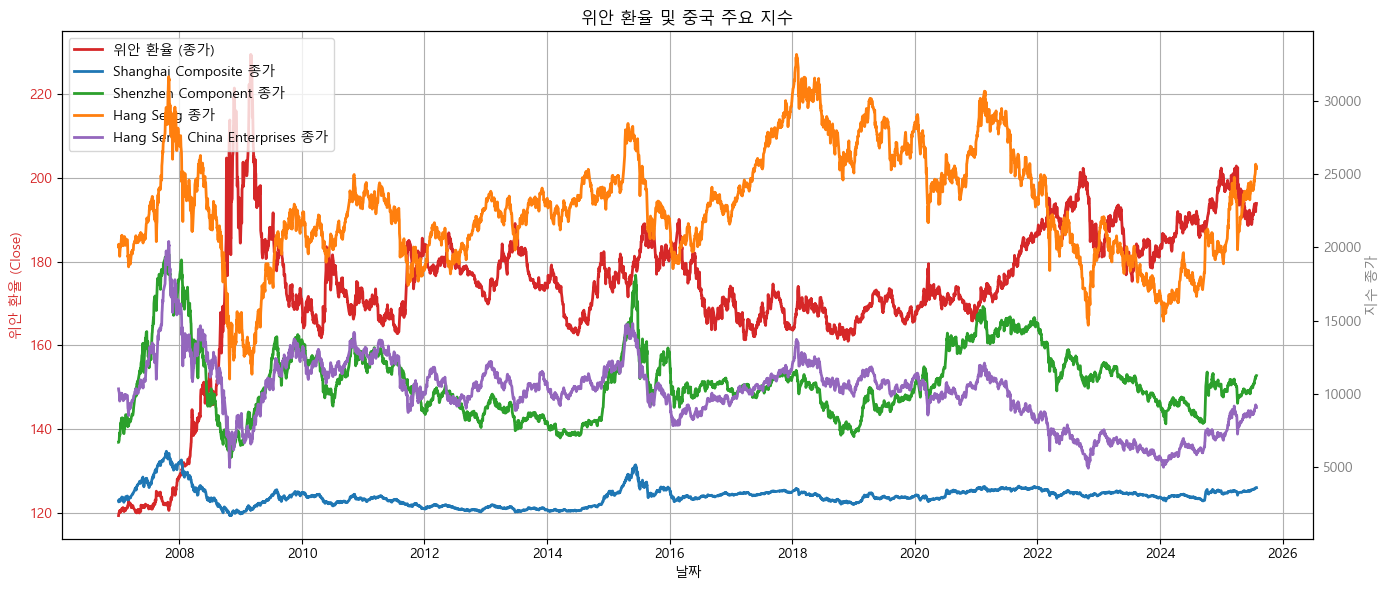

In [23]:
import matplotlib.pyplot as plt

# 이중 축 생성
fig, ax1 = plt.subplots(figsize=(14, 6))

# 왼쪽 y축: 위안 환율 (Close)
ax1.plot(df_base['Date'], df_base['Close'], label='위안 환율 (종가)', color='tab:red', linewidth=2)
ax1.set_xlabel("날짜")
ax1.set_ylabel("위안 환율 (Close)", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True)

# 오른쪽 y축: 중국 주요 지수
ax2 = ax1.twinx()
ax2.plot(df_base['Date'], df_base['Shanghai Composite_Close'], label='Shanghai Composite 종가', color='tab:blue', linewidth=2)
ax2.plot(df_base['Date'], df_base['Shenzhen Component_Close'], label='Shenzhen Component 종가', color='tab:green', linewidth=2)
ax2.plot(df_base['Date'], df_base['Hang Seng_Close'], label='Hang Seng 종가', color='tab:orange', linewidth=2)
ax2.plot(df_base['Date'], df_base['Hang Seng China Enterprises_Close'], label='Hang Seng China Enterprises 종가', color='tab:purple', linewidth=2)
ax2.set_ylabel("지수 종가", color='tab:gray')
ax2.tick_params(axis='y', labelcolor='tab:gray')

# 범례 병합
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 제목과 레이아웃
plt.title("위안 환율 및 중국 주요 지수")
plt.tight_layout()
plt.show()

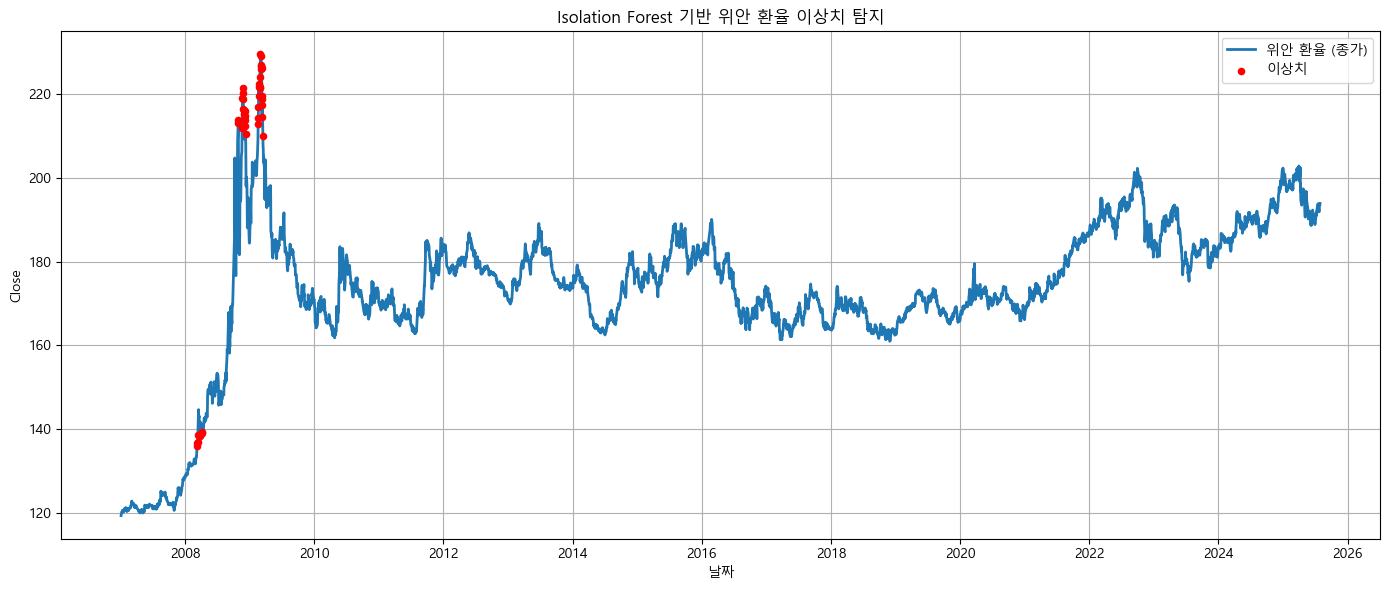

In [25]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 1. 결측 제거 및 데이터 준비
df = df_base.copy()
df = df[['Date', 'Close']].dropna()

# 2. Isolation Forest 적용
model = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = model.fit_predict(df[['Close']])

# 3. 이상치 추출
anomalies = df[df['anomaly'] == -1]

# 4. 시각화
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='위안 환율 (종가)', color='tab:blue', linewidth=2)
plt.scatter(anomalies['Date'], anomalies['Close'], color='red', label='이상치', s=20, zorder=5)
plt.title("Isolation Forest 기반 위안 환율 이상치 탐지")
plt.xlabel("날짜")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 하루 예측

C:\Users\campus4D044\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
📊 XGBoost
    MAE:  1.8998
    RMSE: 2.4294
    R²:   0.8123
📊 LSTM
    MAE:  1.2782
    RMSE: 1.6763
    R²:   0.9106
📊 RandomForest
    MAE:  1.4079
    RMSE: 1.8050
    R²:   0.8964


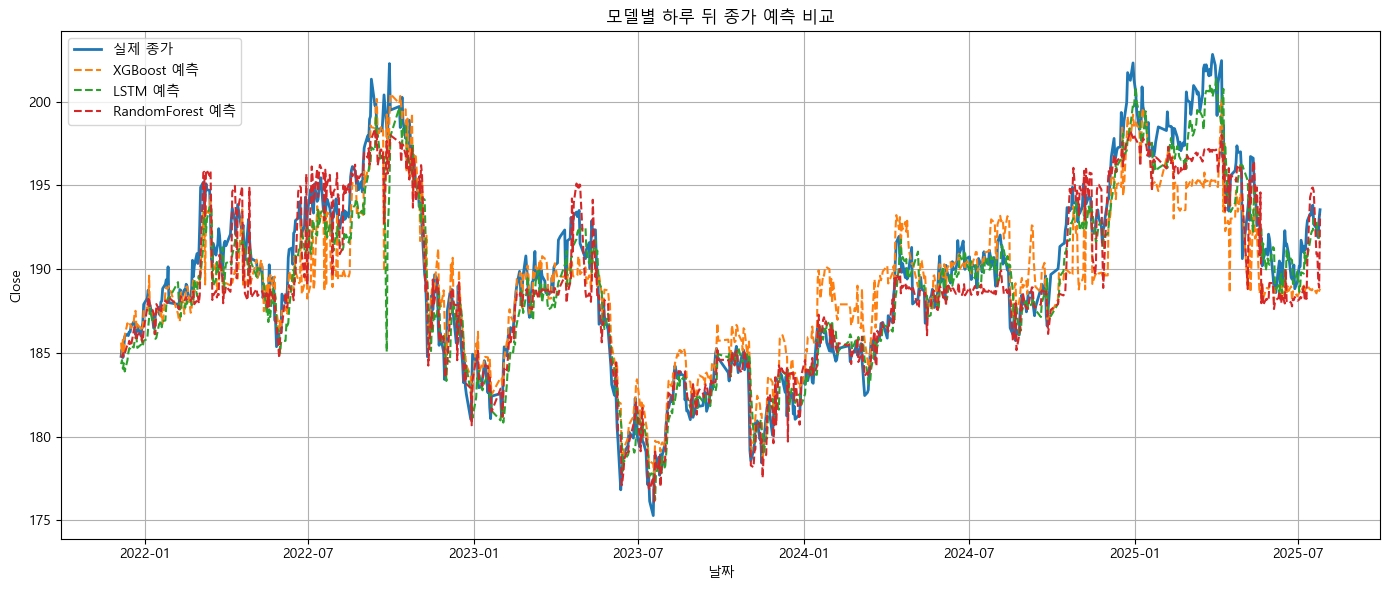

In [124]:
# 1. 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 2. 데이터 준비
df = df_base.copy()  # 기존 df_base를 유지
df = df.sort_values('Date')
df['Date'] = pd.to_datetime(df['Date'])
df['target'] = df['Close'].shift(-1)
df = df.dropna().reset_index(drop=True)

# 3. 피처, 타겟 설정
drop_cols = ['Date', '기준년월', 'return', 'return_future', 'target', 'next_day_close']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['target'].values

# 4. 학습/테스트 분할
split_idx = int(len(df) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_raw, y_test_raw = y[:split_idx], y[split_idx:]

# 5. 정규화
scaler_X = MinMaxScaler().fit(X_train_raw)
X_train_scaled = scaler_X.transform(X_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

scaler_y = MinMaxScaler().fit(y_train_raw.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train_raw.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

# 6. 시퀀스 생성 함수
def make_sequence(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

seq_len = 20
X_train_seq, y_train_seq = make_sequence(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = make_sequence(X_test_scaled, y_test_scaled, seq_len)

X_train_flat = X_train_scaled[seq_len:][:len(X_train_seq)]
X_test_flat  = X_test_scaled[seq_len:][:len(X_test_seq)]
y_train_flat = y_train_scaled[seq_len:][:len(X_train_seq)]
y_test_flat  = y_test_scaled[seq_len:][:len(X_test_seq)]

# 7. 모델 훈련 및 예측
## XGBoost
model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
model_xgb.fit(X_train_flat, y_train_flat.ravel())
y_pred_xgb = scaler_y.inverse_transform(model_xgb.predict(X_test_flat).reshape(-1, 1)).reshape(-1)

## LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(seq_len, X_train_seq.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=15, restore_best_weights=True)
model_lstm.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.2,
               callbacks=[early_stop], verbose=0)
y_pred_lstm = scaler_y.inverse_transform(model_lstm.predict(X_test_seq)).reshape(-1)

## RandomForest
model_rf = RandomForestRegressor(n_estimators=200, random_state=42)
model_rf.fit(X_train_flat, y_train_flat.ravel())
y_pred_rf = scaler_y.inverse_transform(model_rf.predict(X_test_flat).reshape(-1, 1)).reshape(-1)

# 8. 실제값 복원
y_true = scaler_y.inverse_transform(y_test_seq).reshape(-1)

# 9. 성능 출력
for name, pred in zip(['XGBoost', 'LSTM', 'RandomForest'],
                      [y_pred_xgb, y_pred_lstm, y_pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    mae = mean_absolute_error(y_true, pred)
    r2 = r2_score(y_true, pred)
    print(f"📊 {name}")
    print(f"    MAE:  {mae:.4f}")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    R²:   {r2:.4f}")

# 10. 시각화
date_test = df['Date'].iloc[seq_len + split_idx:].reset_index(drop=True)
n = min(len(date_test), len(y_true), len(y_pred_xgb), len(y_pred_lstm), len(y_pred_rf))

plt.figure(figsize=(14, 6))
plt.plot(date_test[:n], y_true[:n], label='실제 종가', linewidth=2)
plt.plot(date_test[:n], y_pred_xgb[:n], label='XGBoost 예측', linestyle='--')
plt.plot(date_test[:n], y_pred_lstm[:n], label='LSTM 예측', linestyle='--')
plt.plot(date_test[:n], y_pred_rf[:n], label='RandomForest 예측', linestyle='--')
plt.title("모델별 하루 뒤 종가 예측 비교")
plt.xlabel("날짜")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [126]:
import joblib
joblib.dump(model_lstm, 'yuan_하루.pkl')
joblib.dump(scaler_X, 'yuan_scaler_X_하루.pkl')
joblib.dump(scaler_y, 'yuan_scaler_y_하루.pkl')

['yuan_scaler_y_하루.pkl']

# 일주일 예측

C:\Users\campus4D044\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
📊 XGBoost
    MAE:  4.0749
    RMSE: 5.1272
    R²:   0.1640
📊 LSTM
    MAE:  3.7941
    RMSE: 4.3109
    R²:   0.4090
📊 RandomForest
    MAE:  3.5313
    RMSE: 4.6039
    R²:   0.3260


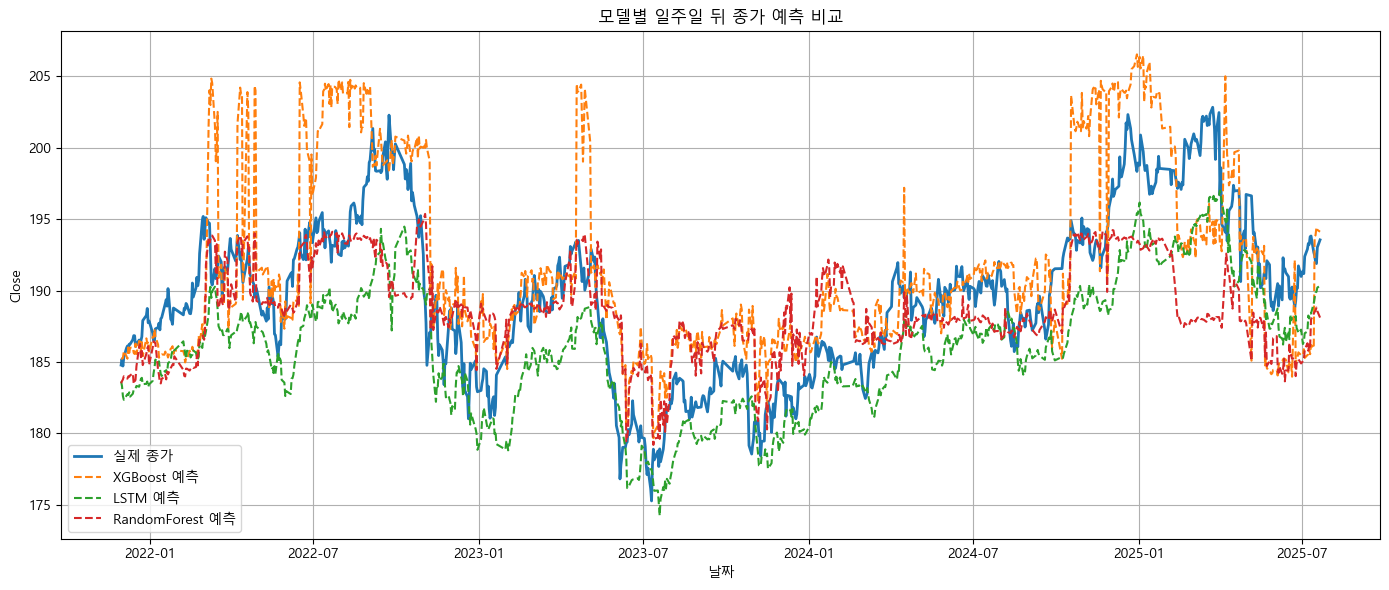

In [127]:
# 1. 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 2. 데이터 준비
df = df_base.copy()  # 기존 df_base를 유지
df = df.sort_values('Date')
df['Date'] = pd.to_datetime(df['Date'])
df['target'] = df['Close'].shift(-5)
df = df.dropna().reset_index(drop=True)

# 3. 피처, 타겟 설정
drop_cols = ['Date', '기준년월', 'return', 'return_future', 'target', 'next_day_close']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['target'].values

# 4. 학습/테스트 분할
split_idx = int(len(df) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_raw, y_test_raw = y[:split_idx], y[split_idx:]

# 5. 정규화
scaler_X = MinMaxScaler().fit(X_train_raw)
X_train_scaled = scaler_X.transform(X_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

scaler_y = MinMaxScaler().fit(y_train_raw.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train_raw.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

# 6. 시퀀스 생성 함수
def make_sequence(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

seq_len = 20
X_train_seq, y_train_seq = make_sequence(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = make_sequence(X_test_scaled, y_test_scaled, seq_len)

X_train_flat = X_train_scaled[seq_len:][:len(X_train_seq)]
X_test_flat  = X_test_scaled[seq_len:][:len(X_test_seq)]
y_train_flat = y_train_scaled[seq_len:][:len(X_train_seq)]
y_test_flat  = y_test_scaled[seq_len:][:len(X_test_seq)]

# 7. 모델 훈련 및 예측
## XGBoost
model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
model_xgb.fit(X_train_flat, y_train_flat.ravel())
y_pred_xgb = scaler_y.inverse_transform(model_xgb.predict(X_test_flat).reshape(-1, 1)).reshape(-1)

## LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(seq_len, X_train_seq.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=15, restore_best_weights=True)
model_lstm.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.2,
               callbacks=[early_stop], verbose=0)
y_pred_lstm = scaler_y.inverse_transform(model_lstm.predict(X_test_seq)).reshape(-1)

## RandomForest
model_rf = RandomForestRegressor(n_estimators=200, random_state=42)
model_rf.fit(X_train_flat, y_train_flat.ravel())
y_pred_rf = scaler_y.inverse_transform(model_rf.predict(X_test_flat).reshape(-1, 1)).reshape(-1)

# 8. 실제값 복원
y_true = scaler_y.inverse_transform(y_test_seq).reshape(-1)

# 9. 성능 출력
for name, pred in zip(['XGBoost', 'LSTM', 'RandomForest'],
                      [y_pred_xgb, y_pred_lstm, y_pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    mae = mean_absolute_error(y_true, pred)
    r2 = r2_score(y_true, pred)
    print(f"📊 {name}")
    print(f"    MAE:  {mae:.4f}")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    R²:   {r2:.4f}")

# 10. 시각화
date_test = df['Date'].iloc[seq_len + split_idx:].reset_index(drop=True)
n = min(len(date_test), len(y_true), len(y_pred_xgb), len(y_pred_lstm), len(y_pred_rf))

plt.figure(figsize=(14, 6))
plt.plot(date_test[:n], y_true[:n], label='실제 종가', linewidth=2)
plt.plot(date_test[:n], y_pred_xgb[:n], label='XGBoost 예측', linestyle='--')
plt.plot(date_test[:n], y_pred_lstm[:n], label='LSTM 예측', linestyle='--')
plt.plot(date_test[:n], y_pred_rf[:n], label='RandomForest 예측', linestyle='--')
plt.title("모델별 일주일 뒤 종가 예측 비교")
plt.xlabel("날짜")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [128]:
import joblib
joblib.dump(model_lstm, 'yuan_일주일.pkl')
joblib.dump(scaler_X, 'yuan_scaler_X_일주일.pkl')
joblib.dump(scaler_y, 'yuan_scaler_y_일주일.pkl')

['yuan_scaler_y_일주일.pkl']

# 한달 예측

C:\Users\campus4D044\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
📊 XGBoost
    MAE:  6.6114
    RMSE: 7.8961
    R²:   -0.9806
📊 LSTM
    MAE:  6.8449
    RMSE: 7.7611
    R²:   -0.9135
📊 RandomForest
    MAE:  6.0727
    RMSE: 7.2892
    R²:   -0.6879


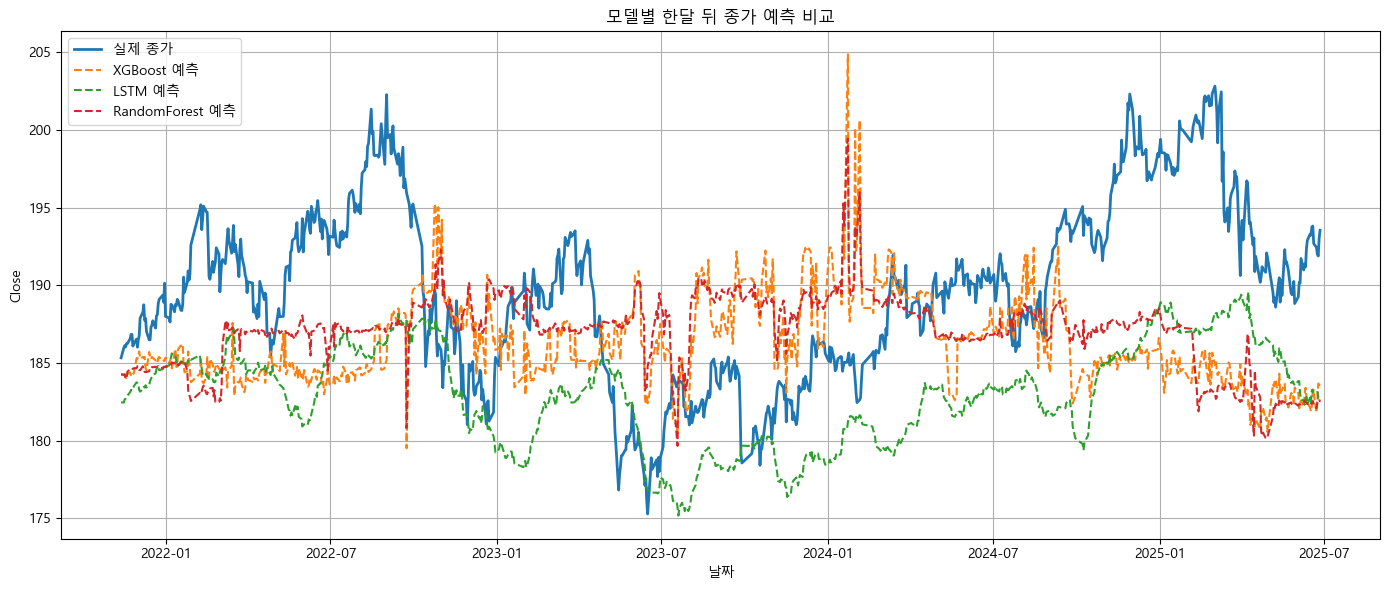

In [129]:
# 1. 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 2. 데이터 준비
df = df_base.copy()  # 기존 df_base를 유지
df = df.sort_values('Date')
df['Date'] = pd.to_datetime(df['Date'])
df['target'] = df['Close'].shift(-20)
df = df.dropna().reset_index(drop=True)

# 3. 피처, 타겟 설정
drop_cols = ['Date', '기준년월', 'return', 'return_future', 'target', 'next_day_close']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['target'].values

# 4. 학습/테스트 분할
split_idx = int(len(df) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_raw, y_test_raw = y[:split_idx], y[split_idx:]

# 5. 정규화
scaler_X = MinMaxScaler().fit(X_train_raw)
X_train_scaled = scaler_X.transform(X_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

scaler_y = MinMaxScaler().fit(y_train_raw.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train_raw.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

# 6. 시퀀스 생성 함수
def make_sequence(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

seq_len = 20
X_train_seq, y_train_seq = make_sequence(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = make_sequence(X_test_scaled, y_test_scaled, seq_len)

X_train_flat = X_train_scaled[seq_len:][:len(X_train_seq)]
X_test_flat  = X_test_scaled[seq_len:][:len(X_test_seq)]
y_train_flat = y_train_scaled[seq_len:][:len(X_train_seq)]
y_test_flat  = y_test_scaled[seq_len:][:len(X_test_seq)]

# 7. 모델 훈련 및 예측
## XGBoost
model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
model_xgb.fit(X_train_flat, y_train_flat.ravel())
y_pred_xgb = scaler_y.inverse_transform(model_xgb.predict(X_test_flat).reshape(-1, 1)).reshape(-1)

## LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(seq_len, X_train_seq.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=15, restore_best_weights=True)
model_lstm.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.2,
               callbacks=[early_stop], verbose=0)
y_pred_lstm = scaler_y.inverse_transform(model_lstm.predict(X_test_seq)).reshape(-1)

## RandomForest
model_rf = RandomForestRegressor(n_estimators=200, random_state=42)
model_rf.fit(X_train_flat, y_train_flat.ravel())
y_pred_rf = scaler_y.inverse_transform(model_rf.predict(X_test_flat).reshape(-1, 1)).reshape(-1)

# 8. 실제값 복원
y_true = scaler_y.inverse_transform(y_test_seq).reshape(-1)

# 9. 성능 출력
for name, pred in zip(['XGBoost', 'LSTM', 'RandomForest'],
                      [y_pred_xgb, y_pred_lstm, y_pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    mae = mean_absolute_error(y_true, pred)
    r2 = r2_score(y_true, pred)
    print(f"📊 {name}")
    print(f"    MAE:  {mae:.4f}")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    R²:   {r2:.4f}")

# 10. 시각화
date_test = df['Date'].iloc[seq_len + split_idx:].reset_index(drop=True)
n = min(len(date_test), len(y_true), len(y_pred_xgb), len(y_pred_lstm), len(y_pred_rf))

plt.figure(figsize=(14, 6))
plt.plot(date_test[:n], y_true[:n], label='실제 종가', linewidth=2)
plt.plot(date_test[:n], y_pred_xgb[:n], label='XGBoost 예측', linestyle='--')
plt.plot(date_test[:n], y_pred_lstm[:n], label='LSTM 예측', linestyle='--')
plt.plot(date_test[:n], y_pred_rf[:n], label='RandomForest 예측', linestyle='--')
plt.title("모델별 한달 뒤 종가 예측 비교")
plt.xlabel("날짜")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [130]:
import joblib
joblib.dump(model_rf, 'yuan_한달.pkl')
joblib.dump(scaler_X, 'yuan_scaler_X_한달.pkl')
joblib.dump(scaler_y, 'yuan_scaler_y_한달.pkl')

['yuan_scaler_y_한달.pkl']

# 세달 예측

C:\Users\campus4D044\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
📊 XGBoost
    MAE:  11.2937
    RMSE: 12.5784
    R²:   -3.9971
📊 LSTM
    MAE:  14.2085
    RMSE: 15.2078
    R²:   -6.3047
📊 RandomForest
    MAE:  10.2770
    RMSE: 11.9255
    R²:   -3.4918


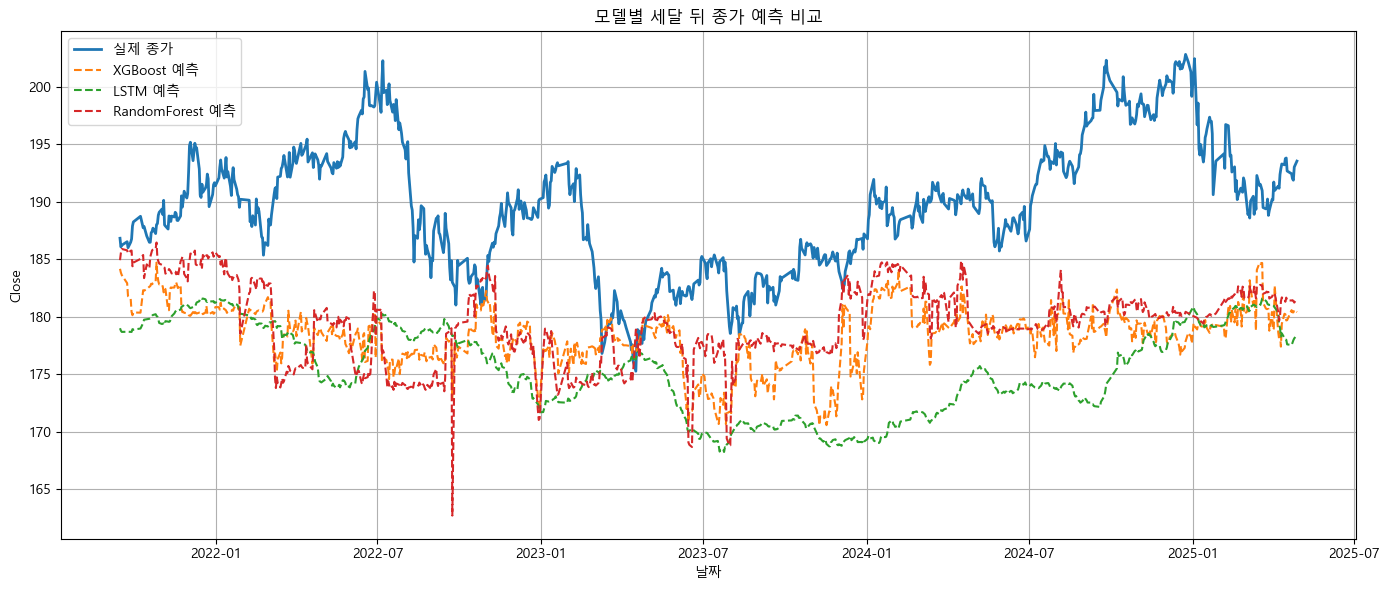

In [131]:
# 1. 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 2. 데이터 준비
df = df_base.copy()  # 기존 df_base를 유지
df = df.sort_values('Date')
df['Date'] = pd.to_datetime(df['Date'])
df['target'] = df['Close'].shift(-60)
df = df.dropna().reset_index(drop=True)

# 3. 피처, 타겟 설정
drop_cols = ['Date', '기준년월', 'return', 'return_future', 'target', 'next_day_close']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['target'].values

# 4. 학습/테스트 분할
split_idx = int(len(df) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_raw, y_test_raw = y[:split_idx], y[split_idx:]

# 5. 정규화
scaler_X = MinMaxScaler().fit(X_train_raw)
X_train_scaled = scaler_X.transform(X_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

scaler_y = MinMaxScaler().fit(y_train_raw.reshape(-1, 1))
y_train_scaled = scaler_y.transform(y_train_raw.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1))

# 6. 시퀀스 생성 함수
def make_sequence(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

seq_len = 20
X_train_seq, y_train_seq = make_sequence(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = make_sequence(X_test_scaled, y_test_scaled, seq_len)

X_train_flat = X_train_scaled[seq_len:][:len(X_train_seq)]
X_test_flat  = X_test_scaled[seq_len:][:len(X_test_seq)]
y_train_flat = y_train_scaled[seq_len:][:len(X_train_seq)]
y_test_flat  = y_test_scaled[seq_len:][:len(X_test_seq)]

# 7. 모델 훈련 및 예측
## XGBoost
model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
model_xgb.fit(X_train_flat, y_train_flat.ravel())
y_pred_xgb = scaler_y.inverse_transform(model_xgb.predict(X_test_flat).reshape(-1, 1)).reshape(-1)

## LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(seq_len, X_train_seq.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=15, restore_best_weights=True)
model_lstm.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.2,
               callbacks=[early_stop], verbose=0)
y_pred_lstm = scaler_y.inverse_transform(model_lstm.predict(X_test_seq)).reshape(-1)

## RandomForest
model_rf = RandomForestRegressor(n_estimators=200, random_state=42)
model_rf.fit(X_train_flat, y_train_flat.ravel())
y_pred_rf = scaler_y.inverse_transform(model_rf.predict(X_test_flat).reshape(-1, 1)).reshape(-1)

# 8. 실제값 복원
y_true = scaler_y.inverse_transform(y_test_seq).reshape(-1)

# 9. 성능 출력
for name, pred in zip(['XGBoost', 'LSTM', 'RandomForest'],
                      [y_pred_xgb, y_pred_lstm, y_pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    mae = mean_absolute_error(y_true, pred)
    r2 = r2_score(y_true, pred)
    print(f"📊 {name}")
    print(f"    MAE:  {mae:.4f}")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    R²:   {r2:.4f}")

# 10. 시각화
date_test = df['Date'].iloc[seq_len + split_idx:].reset_index(drop=True)
n = min(len(date_test), len(y_true), len(y_pred_xgb), len(y_pred_lstm), len(y_pred_rf))

plt.figure(figsize=(14, 6))
plt.plot(date_test[:n], y_true[:n], label='실제 종가', linewidth=2)
plt.plot(date_test[:n], y_pred_xgb[:n], label='XGBoost 예측', linestyle='--')
plt.plot(date_test[:n], y_pred_lstm[:n], label='LSTM 예측', linestyle='--')
plt.plot(date_test[:n], y_pred_rf[:n], label='RandomForest 예측', linestyle='--')
plt.title("모델별 세달 뒤 종가 예측 비교")
plt.xlabel("날짜")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [132]:
import joblib
joblib.dump(model_rf, 'yuan_세달.pkl')
joblib.dump(scaler_X, 'yuan_scaler_X_세달.pkl')
joblib.dump(scaler_y, 'yuan_scaler_y_세달.pkl')

['yuan_scaler_y_세달.pkl']

|모델|하루|일주일|한달|세달|
|---|---|---|---|---|
|XGBoost|0.8123|0.1640|-0.9806|-3.9971|
|LSTM|0.9106|0.4090|-0.9135|-6.3047|
|RandomForest|0.8964|0.3260|-0.6879|-3.4918|
||||||
|최종모델|LSTM|LSTM|RandomForest|RandomForest

In [138]:
def yuan_predict_하루(new_df):
    import joblib
    
    scaler_X = joblib.load(f'yuan_scaler_X_하루.pkl')

    scaler_y = joblib.load(f'yuan_scaler_y_하루.pkl')
    
    model_lstm = joblib.load(f'yuan_하루.pkl')

    X_new = new_df.drop(columns=drop_cols, errors='ignore')
    X_new_scaled = scaler_X.transform(X_new)

    X_new_seq = []
    for i in range(len(X_new_scaled) - seq_len):
        X_new_seq.append(X_new_scaled[i:i+seq_len])
    X_new_seq = np.array(X_new_seq)

    y_pred_lstm = model_lstm.predict(X_new_seq)

    y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm).reshape(-1)

    # 6. 결과 반환
    return y_pred_lstm

import cloudpickle
with open("yuan_predict_하루.pkl", "wb") as f:
    cloudpickle.dump(yuan_predict_하루, f)

In [139]:
def yuan_predict_일주일(new_df):
    import joblib
    
    scaler_X = joblib.load(f'yuan_scaler_X_일주일.pkl')

    scaler_y = joblib.load(f'yuan_scaler_y_일주일.pkl')
    
    model_lstm = joblib.load(f'yuan_일주일.pkl')

    X_new = new_df.drop(columns=drop_cols, errors='ignore')
    X_new_scaled = scaler_X.transform(X_new)

    X_new_seq = []
    for i in range(len(X_new_scaled) - seq_len):
        X_new_seq.append(X_new_scaled[i:i+seq_len])
    X_new_seq = np.array(X_new_seq)

    y_pred_lstm = model_lstm.predict(X_new_seq)

    y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm).reshape(-1)

    # 6. 결과 반환
    return y_pred_lstm

with open("yuan_predict_일주일.pkl", "wb") as f:
    cloudpickle.dump(yuan_predict_일주일, f)

In [140]:
def yuan_predict_한달(new_df):
    import joblib
    
    scaler_X = joblib.load(f'yuan_scaler_X_한달.pkl')

    scaler_y = joblib.load(f'yuan_scaler_y_한달.pkl')
    
    model_rf = joblib.load(f'yuan_한달.pkl')

    X_new = new_df.drop(columns=drop_cols, errors='ignore')
    X_new_scaled = scaler_X.transform(X_new)

    X_new_flat = X_new_scaled[seq_len:]

    y_pred_rf = model_rf.predict(X_new_flat)
    
    y_pred_rf = scaler_y.inverse_transform(y_pred_rf.reshape(-1, 1)).reshape(-1)

    # 6. 결과 반환
    return y_pred_rf

with open("yuan_predict_한달.pkl", "wb") as f:
    cloudpickle.dump(yuan_predict_한달, f)

In [141]:
def yuan_predict_세달(new_df):
    import joblib
    
    scaler_X = joblib.load(f'yuan_scaler_X_세달.pkl')

    scaler_y = joblib.load(f'yuan_scaler_y_세달.pkl')
    
    model_rf = joblib.load(f'yuan_세달.pkl')

    X_new = new_df.drop(columns=drop_cols, errors='ignore')
    X_new_scaled = scaler_X.transform(X_new)

    X_new_flat = X_new_scaled[seq_len:]

    y_pred_rf = model_rf.predict(X_new_flat)
    
    y_pred_rf = scaler_y.inverse_transform(y_pred_rf.reshape(-1, 1)).reshape(-1)

    # 6. 결과 반환
    return y_pred_rf

with open("yuan_predict_세달.pkl", "wb") as f:
    cloudpickle.dump(yuan_predict_세달, f)

In [134]:
print(list(X))

['Shanghai Composite_Open', 'Shanghai Composite_High', 'Shanghai Composite_Low', 'Shanghai Composite_Close', 'Shenzhen Component_Open', 'Shenzhen Component_High', 'Shenzhen Component_Low', 'Shenzhen Component_Close', 'Hang Seng_Open', 'Hang Seng_High', 'Hang Seng_Low', 'Hang Seng_Close', 'Hang Seng China Enterprises_Open', 'Hang Seng China Enterprises_High', 'Hang Seng China Enterprises_Low', 'Hang Seng China Enterprises_Close', 'Close', 'Open', 'High', 'Low', 'Change']


In [167]:
def yuan_predict(timelength):
    import pickle

    yuan_df=pd.read_csv('yuan_df.csv')

    with open('yuan_real_times.pkl', 'rb') as f:
        yuan_real_times = pickle.load(f)
        
    with open('yuan_indicator.pkl', 'rb') as f:
        yuan_indicator = pickle.load(f)

    yuan_df['Date']=pd.to_datetime(yuan_df['Date'])

    yuan_df=pd.concat([yuan_df,CNYKRW()],ignore_index=True).drop_duplicates(subset='Date',keep='last')
    yuan_df["Change"] = yuan_df["Close"].diff()
    yuan_df.to_csv('yuan_df.csv',index=False)
    
    new_df=pd.merge(yuan_df,yuan_indicator(),on='Date').tail(21)
    X_new = new_df[['Shanghai Composite_Open', 'Shanghai Composite_High', 'Shanghai Composite_Low', 'Shanghai Composite_Close', 'Shenzhen Component_Open', 'Shenzhen Component_High', 'Shenzhen Component_Low', 'Shenzhen Component_Close', 'Hang Seng_Open', 'Hang Seng_High', 'Hang Seng_Low', 'Hang Seng_Close', 'Hang Seng China Enterprises_Open', 'Hang Seng China Enterprises_High', 'Hang Seng China Enterprises_Low', 'Hang Seng China Enterprises_Close', 'Close', 'Open', 'High', 'Low', 'Change']]

    with open(f'yuan_predict_{timelength}.pkl', 'rb') as f:
        model_predict = pickle.load(f)
        
    result_df = pd.DataFrame({
        "Date": new_df['Date'].iloc[-1],
        "Previous Close": new_df['Close'].iloc[-1],
        "Predicted Close": model_predict(X_new),
        "예측결과": np.where(model_predict(X_new) > new_df['Close'].iloc[-1], "상승", "하락")
    })
    
    return result_df
    
with open("yuan_predict.pkl", "wb") as f:
    cloudpickle.dump(yuan_predict, f)

In [168]:
yuan_predict('일주일')

C:\Users\campus4D044\AppData\Local\Temp\ipykernel_31848\24424896.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


,Date,Previous Close,Predicted Close,예측결과
0,2025-07-28,193.55,189.584824,하락
